# Source localization using `sample` data

See also:

http://mne-tools.github.io/dev/auto_tutorials/index.html#source-modeling

Outline:

1. Raw->Epochs->Evoked
2. Create a forward model
3. Compute a dipole fit (ECD)
4. Compute a minimum-norm solution
5. Compute LCMV beamformer
6. Compute sparse source estimate

In [1]:
%matplotlib qt
from mayavi import mlab

import os.path as op
import mne
data_path = mne.datasets.sample.data_path()
print(data_path)
subject = 'sample'
subjects_dir = op.join(data_path, 'subjects')

/Users/larsoner/mne_data/MNE-sample-data


## Load the raw data

In [2]:
fname_raw = op.join(data_path, 'MEG', 'sample',
                    'sample_audvis_filt-0-40_raw.fif')

In [3]:
raw = mne.io.read_raw_fif(fname_raw)
print(raw)

<Raw  |  sample_audvis_filt-0-40_raw.fif, n_channels x n_times : 376 x 41700 (277.7 sec), ~3.6 MB, data not loaded>


## Epoch the data

In [4]:
events = mne.find_events(raw)
event_id = {'Auditory/Left': 1, 'Auditory/Right': 2,
            'Visual/Left': 3, 'Visual/Right': 4,
            'Smiley': 5, 'Button': 32}
epochs = mne.Epochs(raw, events, event_id, preload=True)
print(epochs)

<Epochs  |   319 events (all good), -0.199795 - 0.499488 sec, baseline [None, 0], ~100.6 MB, data loaded,
 'Auditory/Left': 72
 'Auditory/Right': 73
 'Button': 16
 'Smiley': 15
 'Visual/Left': 73
 'Visual/Right': 70>


In [5]:
evoked_l = epochs['Auditory/Left'].average()
print(evoked_l)

<Evoked  |  'Auditory/Left' (average, N=72), [-0.1998, 0.49949] sec, 366 ch, ~3.9 MB>


## Compute a covariance

In [6]:
cov = mne.compute_covariance(epochs, tmax=0., method='shrunk', verbose=True)
print(cov)

Computing data rank from raw with rank=None
    Using tolerance 7.6e-09 (2.2e-16 eps * 305 dim * 1.1e+05  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projectors
    Using tolerance 3.9e-11 (2.2e-16 eps * 59 dim * 2.9e+03  max singular value)
    Estimated rank (eeg): 58
    EEG: rank 58 computed from 59 data channels with 1 projector
    Created an SSP operator (subspace dimension = 4)
    Setting small MEG eigenvalues to zero (without PCA)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 364 -> 360
Estimating covariance using SHRUNK
Done.
Number of samples used : 9889
[done]
<Covariance  |  size : 364 x 364, n_samples : 9889, data : [[2.61203344e-23 6.57026989e-24 7.21879430e-25 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.57026989e-24 9.22431515e-24 1.52307261e-25 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.21879430e-25 1.52307261e-25 6.50446099e-26 ... 0.000000

In [7]:
mne.viz.plot_cov(cov, epochs.info)

(<Figure size 1140x370 with 6 Axes>, <Figure size 1140x370 with 3 Axes>)

### Look at whitened data

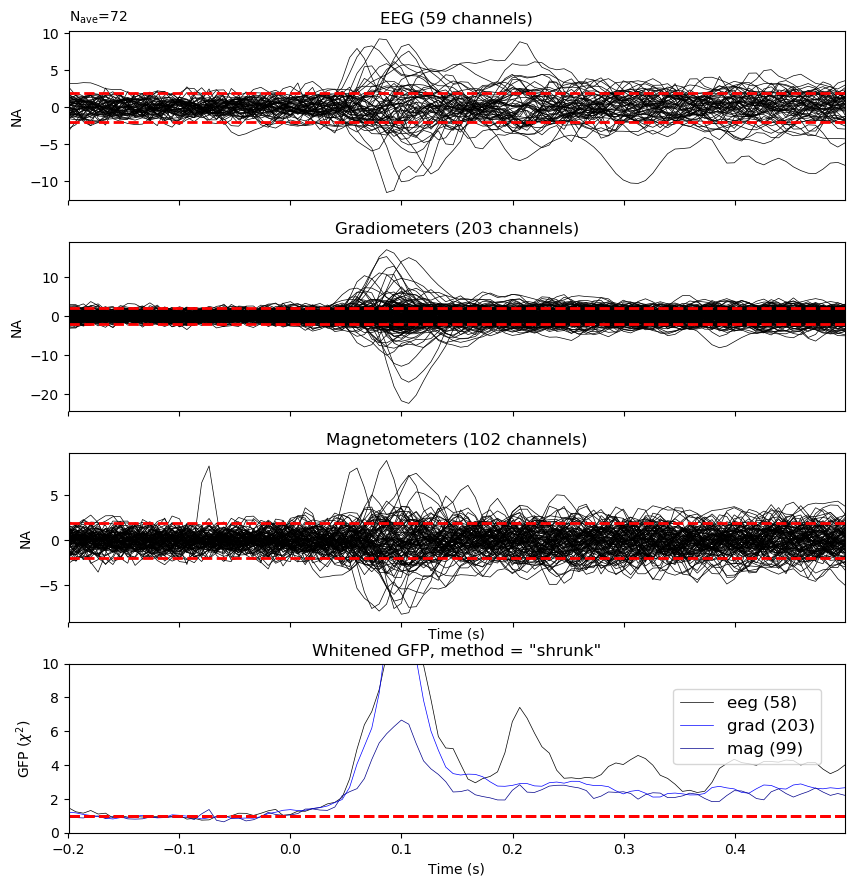

In [8]:
evoked_l.plot_white(cov)

## Go from sensor to source space

Three components that we'll need to compute a forward solution (`fwd`):

1. Head<->MRI transformation (`trans`)
2. Conductor model (`bem`)
3. Source space (`src`)

### Make a *head<->MRI transformation matrix*

This can be done with:
```Console
$ cd ~/mne_data/MNE-sample-data
$ mne coreg -d subjects -s sample --fif MEG/sample/sample_audvis_raw.fif
```

In [9]:
fname_trans = op.join(data_path, 'MEG', 'sample',
                      'sample_audvis_raw-trans.fif')
assert op.isfile(fname_trans)
trans = mne.read_trans(fname_trans)

### Make a *conductor model*

In [10]:
bem_model = mne.make_bem_model(subject, subjects_dir=subjects_dir, verbose=True)

Creating the BEM geometry...
Going from 4th to 4th subdivision of an icosahedron (n_tri: 5120 -> 5120)
Going from 4th to 4th subdivision of an icosahedron (n_tri: 5120 -> 5120)
Going from 4th to 4th subdivision of an icosahedron (n_tri: 5120 -> 5120)
outer skin  CM is  -0.12  -0.14  22.79 mm
outer skull CM is   0.70  -9.88  44.01 mm
inner skull CM is   0.67 -10.01  44.26 mm
Checking that outer skull surface is inside outer skin  surface...
Checking that inner skull surface is inside outer skull surface...
Checking distance between outer skin  and outer skull surfaces...
Minimum distance between the outer skin  and outer skull surfaces is approximately    0.0 mm
Checking distance between outer skull and inner skull surfaces...
Minimum distance between the outer skull and inner skull surfaces is approximately    0.0 mm
Surfaces passed the basic topology checks.
Complete.



In [11]:
fname_model = op.join(subjects_dir, subject, 'bem',
                      '%s-5120-5120-5120-bem.fif' % subject)
# Usually:
# mne.write_bem_surfaces(fname_model, bem_model)
assert op.isfile(fname_model)

In [12]:
fname_bem = op.join(subjects_dir, subject, 'bem',
                    '%s-5120-5120-5120-bem-sol.fif' % subject)
# Usually:
# bem = mne.make_bem_solution(bem_model, verbose=True)
# mne.write_bem_solution(fname_bem, bem)
assert op.isfile(fname_bem)
bem = mne.read_bem_solution(fname_bem)

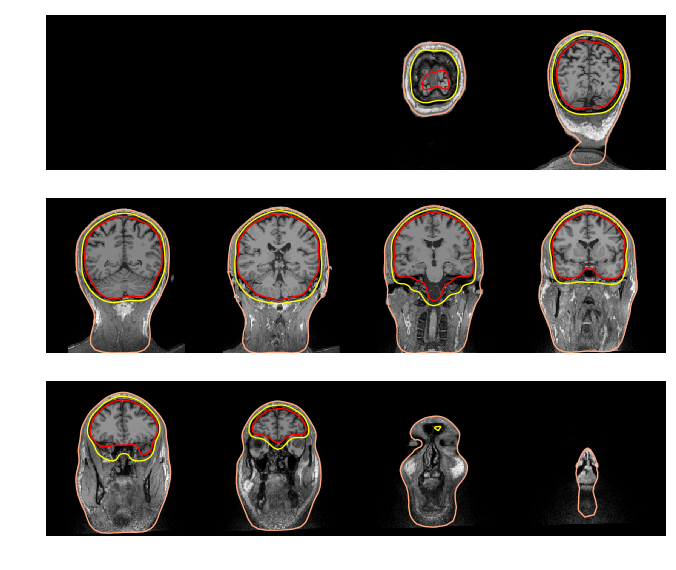

In [13]:
mne.viz.plot_bem(subject, subjects_dir)

### Make a *source space*

In [14]:
# cortical source space:
src = mne.setup_source_space(subject, subjects_dir=subjects_dir,
                             add_dist=False,  # just for speed!
                             verbose=True)

Setting up the source space with the following parameters:

SUBJECTS_DIR = /Users/larsoner/mne_data/MNE-sample-data/subjects
Subject      = sample
Surface      = white
Octahedron subdivision grade 6

>>> 1. Creating the source space...

Doing the octahedral vertex picking...
Loading /Users/larsoner/mne_data/MNE-sample-data/subjects/sample/surf/lh.white...
Mapping lh sample -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from /Users/larsoner/mne_data/MNE-sample-data/subjects/sample/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 4098/155407 selected to source space (oct = 6)

Loading /Users/larsoner/mne_data/MNE-sample-data/subjects/sample/surf/rh.white...
Mapping rh sample -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from /Users/larsoner/mne_data/MNE-sample-data/subjects/sample/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
loaded rh.white 4098/156866 se

In [15]:
fname_src = op.join(subjects_dir, subject, 'bem',
                    '%s-oct-6-src.fif' % subject)
# Usually:
# mne.write_source_spaces(fname_src, src)
assert op.isfile(fname_src)

In [16]:
mne.viz.plot_alignment(evoked_l.info, bem=bem, trans=trans,
                       coord_frame='meg', show_axes=True, src=src,
                       dig=True, surfaces=('head', 'inner_skull', 'outer_skull'))

## Combine these to make a forward model

In [19]:
fname_fwd = op.join(data_path, 'MEG', 'sample',
                    'sample_audvis-meg-eeg-oct-6-fwd.fif')
# Usually:
# fwd = mne.make_forward_solution(
#     evoked_l.info, trans, src, bem, verbose=True)
# mne.write_forward_solution(fname_fwd, fwd)
assert op.isfile(fname_fwd)
fwd = mne.read_forward_solution(fname_fwd)

## Compute a dipole fit

In [17]:
t = evoked_l.get_peak('grad')[1]
print(t)

0.08657792570196808


In [22]:
dip = mne.fit_dipole(evoked_l.copy().crop(t, t),
                     cov, bem, trans, verbose=True)[0]

BEM               : <ConductorModel  |  BEM (3 layers)>
MRI transform     : instance of Transform
Head origin       :   -4.3   18.4   67.0 mm rad =   71.8 mm.
Guess grid        :   20.0 mm
Guess mindist     :    5.0 mm
Guess exclude     :   20.0 mm
Using standard MEG coil definitions.

Coordinate transformation: MRI (surface RAS) -> head
     0.999310  0.009985 -0.035787      -3.17 mm
     0.012759  0.812405  0.582954       6.86 mm
     0.034894 -0.583008  0.811716      28.88 mm
     0.000000  0.000000  0.000000       1.00
Coordinate transformation: MEG device -> head
     0.991420 -0.039936 -0.124467      -6.13 mm
     0.060661  0.984012  0.167456       0.06 mm
     0.115790 -0.173570  0.977991      64.74 mm
     0.000000  0.000000  0.000000       1.00
2 bad channels total
Read 305 MEG channels from info
84 coil definitions read
Coordinate transformation: MEG device -> head
     0.991420 -0.039936 -0.124467      -6.13 mm
     0.060661  0.984012  0.167456       0.06 mm
     0.115790 -0

In [23]:
dip

<Dipole  |  n_times : 1, tmin : 0.087, tmax : 0.087>

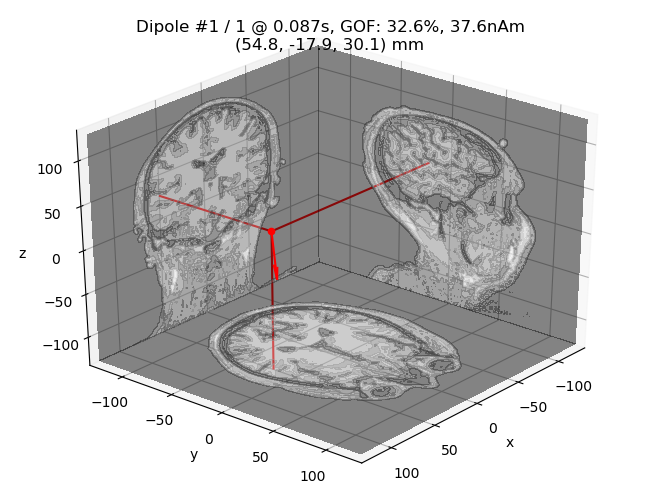

In [24]:
dip.plot_locations(trans, subject, subjects_dir=subjects_dir)

## Compute a MNE solution (dSPM)

In [20]:
inv = mne.minimum_norm.make_inverse_operator(evoked_l.info, fwd, cov,
                                             loose=0.2, depth=0.8,
                                             verbose=True)

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 364 channels.
    364 out of 366 channels remain after picking
Selected 364 channels
Creating the depth weighting matrix...
    203 planar channels
    limit = 7262/7498 = 10.020865
    scale = 2.58122e-08 exp = 0.8
Applying loose dipole orientations. Loose value of 0.2.
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 4)
Computing data rank from covariance with rank=None
    Using tolerance 3.6e-13 (2.2e-16 eps * 305 dim * 5.4  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projectors
    Using tolerance 1.1e-13 (2.2e-16 eps * 59 dim * 8.8  max singular value)
    E

In [26]:
print(inv)

<InverseOperator | MEG channels: 305 | EEG channels: 59 | Source space: surface with 7498 sources | Source orientation: Free>


In [21]:
stc = mne.minimum_norm.apply_inverse(evoked_l, inv, verbose=True)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 72
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 4)
    Created the whitener using a noise covariance matrix with rank 360 (4 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "Auditory/Left"...
    Picked 364 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  64.2% variance
    Combining the current components...
    dSPM...
[done]


In [28]:
print(stc)

<SourceEstimate  |  7498 vertices, subject : sample, tmin : -199.79521315838787 (ms), tmax : 499.48803289596964 (ms), tstep : 6.659840438612929 (ms), data shape : (7498, 106)>


In [ ]:
kwargs = dict(views=['lat', 'med'], hemi='split',
              smoothing_steps=5, subjects_dir=subjects_dir)
brain = stc.plot(time_viewer=True, clim=dict(kind='value', lims=[4, 7, 10]), subjects_dir=subjects_dir)

## Compute LCMV

In [22]:
fwd_fixed = mne.convert_forward_solution(fwd, force_fixed=True)
data_cov = mne.compute_covariance(epochs['Auditory/Left'], tmin=0.04, tmax=0.25,
                                  method='shrunk')
filters = mne.beamformer.make_lcmv(evoked_l.info, fwd_fixed, data_cov,
                                   noise_cov=cov, verbose=True)

Computing data rank from covariance with rank='info'
    MEG: rank 302 after 3 projectors applied to 305 channels
    EEG: rank 58 after 1 projector applied to 59 channels
Computing data rank from covariance with rank='info'
    MEG: rank 302 after 3 projectors applied to 305 channels
    EEG: rank 58 after 1 projector applied to 59 channels
Making LCMV beamformer with rank {'meg': 302, 'eeg': 58}
Computing inverse operator with 364 channels.
    364 out of 366 channels remain after picking
Selected 364 channels
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 4)
Computing data rank from covariance with rank={'meg': 302, 'eeg': 58}
    Setting small MEG eigenvalues to zero (without PCA)
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.


In [24]:
kwargs = dict(views=['lat', 'med'], hemi='split',
              smoothing_steps=5, subjects_dir=subjects_dir)
stc = mne.beamformer.apply_lcmv(evoked_l, filters)
brain = abs(stc).copy().crop(t, t).plot(**kwargs)

## Compute sparse solution

In [25]:
from mne.inverse_sparse import mixed_norm
alpha = 55  # regularization parameter between 0 and 100 (100 is high)
n_mxne_iter = 10  # if > 1 use L0.5/L2 reweighted mixed norm solver

# Compute (ir)MxNE inverse solution with dipole output
stc = mixed_norm(
    evoked_l.copy().crop(0, 0.3),
    fwd, cov, alpha, debias=True, n_mxne_iter=n_mxne_iter,
    verbose=True)
mne.viz.plot_sparse_source_estimates(fwd['src'], stc)

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 364 channels.
    364 out of 366 channels remain after picking
Selected 364 channels
Creating the depth weighting matrix...
Applying loose dipole orientations. Loose value of 0.2.
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 4)
Computing data rank from covariance with rank=None
    Using tolerance 3.6e-13 (2.2e-16 eps * 305 dim * 5.4  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projectors
    Using tolerance 1.1e-13 (2.2e-16 eps * 59 dim * 8.8  max singular value)
    Estimated rank (eeg): 58
    EEG: rank 58 computed from 59 data channels with 1 projector
   